### CSC 5601: Term Project - Isolation Forest (Anomaly Detection) - Sumedha Sanjeev

In [16]:
import pandas as pd
import numpy as np
import sklearn.ensemble as skl_e
from isolation_forest import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Loading & Preprocessing

In [2]:
creditcard = pd.read_csv('data/creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
creditcard.isnull().sum().sum()

0

In [4]:
creditcard['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [9]:
X = creditcard.drop(columns=['Class','Time']).to_numpy()
X.shape

(284807, 29)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Anomaly Detection using Implemented Isolation Forest

In [ ]:
# model = IsolationForest(t=100, sub_sampling_size=256)
# model.fit(X)
# #TODO: change

#### Anomaly Detection using `sklearn.ensemble.IsolationForest`

TODO: descriptions

In [8]:
contamination = creditcard['Class'].mean()
print(f"Estimated contamination: {contamination:.4f}")

Estimated contamination: 0.0017


In [ ]:
iso_forest = skl_e.IsolationForest(contamination=contamination, random_state=42)
creditcard['anomaly_score'] = iso_forest.fit_predict(X_scaled)

# map anomaly predictions
creditcard['anomaly'] = creditcard['anomaly_score'].map({1: 0, -1: 1})  # 1 for anomaly, 0 for normal

# eval anomalies
print(creditcard[['Class', 'anomaly']].value_counts())

Class  anomaly
0      0          283962
       1             353
1      0             353
       1             139
Name: count, dtype: int64


TODO: describe what the above means

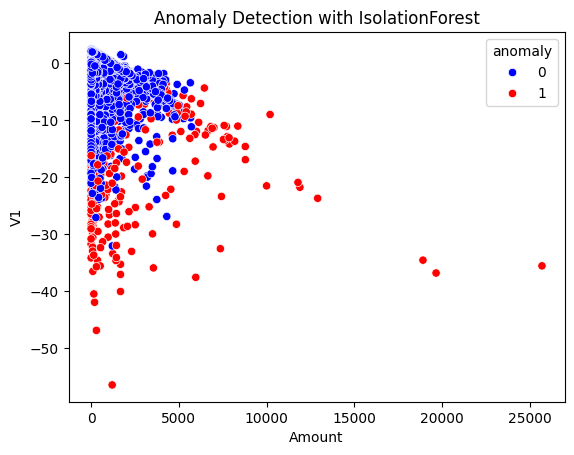

In [17]:
# plotting anomalies over 'Amount' and 'V1'
sns.scatterplot(data=creditcard, x='Amount', y='V1', hue='anomaly', palette={0: "blue", 1: "red"})
plt.title("Anomaly Detection with IsolationForest")
plt.show()

#### Evaluation